In [ ]:
#Using different classification models on the molecular data to predict a GPCR ligand

In [173]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None
import uniprot as up
import pprint
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper



In [ ]:
## First try KNN

In [17]:
#Read in data, need to drop a few columns
df_class = pd.read_csv('df_classification.csv')
df_class.drop(labels = ['Unnamed: 0', 'PubChem CID', 'CID'], axis = 1, inplace = True)

In [58]:
#Drop columns with NA and set features and target
df_class.dropna(inplace = True)
X = df_class.select_dtypes(include = 'number', exclude = 'object')
X.drop(['GPCR'], axis = 1, inplace = True)
y = df_class['GPCR']
X

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount
0,336.5,5.2,336.230059,336.230059,66.8,408,0,2,4,15,24,0,1,1,0,4,4,0
5,336.5,4.1,336.230059,336.230059,77.8,421,0,3,4,14,24,0,2,2,0,4,4,0
13,752.6,5.2,752.164040,752.164040,121.0,1370,0,2,9,9,47,1,8,8,0,0,0,0
14,492.6,4.3,492.174373,492.174373,112.0,705,0,1,9,6,35,0,1,1,0,0,0,0
15,423.6,3.7,423.145048,423.145048,111.0,608,0,3,5,7,28,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15959,408.4,1.9,408.171002,408.171002,109.0,556,0,3,7,9,30,0,0,0,0,0,0,0
15960,356.4,3.1,356.063092,356.063092,67.9,567,0,0,6,3,25,0,0,0,0,0,0,0
15961,445.3,3.7,444.047747,444.047747,74.9,620,0,1,5,5,28,0,0,0,0,0,0,0
15962,383.3,2.0,383.043914,383.043914,95.8,675,0,1,8,3,26,0,3,3,0,0,0,0


In [159]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mapper = DataFrameMapper([(X_train.columns, StandardScaler())])
scaled_X_train = mapper.fit_transform(X_train.copy())
scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = mapper.fit_transform(X_test.copy())
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=X_test.columns)

In [199]:
#Perform KNN and evaluate model on the training data
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(scaled_X_train_df, y_train)
y_train_pred = knn.predict(scaled_X_train_df)
print(accuracy_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(precision_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.f1_score(y_train, y_train_pred))

0.8954180688584003
0.7637033625057578
0.8489503328213006
0.8954180688584003
0.8040737148399613


In [198]:
#Evaluate model on the test data
knn.fit(scaled_X_test_df, y_test)
y_test_pred = knn.predict(scaled_X_test)
print(accuracy_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(metrics.accuracy_score(y_test, y_test_pred))
print(metrics.f1_score(y_test, y_test_pred))

0.9958592132505176
0.9875886524822695
0.9982078853046595
0.9958592132505176
0.9928698752228164


This is a surprisingly good accuracy, but I am more interested in recall. So let's check out the recall and precision. 

So it seems to be struggling with precision and recall, indicating the KNN model may be good at identifying not GPCR molecules but not good at identifying GPCR molecules 

In [197]:
#Try cross validation with the three types for scoring metrics
mapper = DataFrameMapper([(X.columns, StandardScaler())])
scaled_X = mapper.fit_transform(X.copy())
scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)

metrics_ = ['recall', 'precision', 'accuracy']

for metric in metrics_:
    knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
    scores = cross_val_score(knn, scaled_X_df, y, cv=10, scoring=metric)

    print(scores)

[0.58608059 0.55677656 0.82783883 0.72262774 0.59854015 0.70437956
 0.66058394 0.70072993 0.62637363 0.58608059]
[0.54607509 0.55677656 0.62430939 0.66666667 0.74885845 0.79752066
 0.81531532 0.74708171 0.74672489 0.59925094]
[0.74534161 0.7494824  0.81055901 0.81884058 0.82919255 0.86542443
 0.86128364 0.84782609 0.83419689 0.77202073]


In [162]:
#Find optimal K for each metric and each weight type and plot

In [163]:
def opt_k(X,y,metric, weight):
    mapper = DataFrameMapper([(X.columns, StandardScaler())])
    scaled_X = mapper.fit_transform(X.copy())
    scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)
    
    k_range = list(range(1, 31))
    k_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights = weight)
        scores = cross_val_score(knn, scaled_X_df, y, cv=10, scoring= metric)
        k_scores.append(scores.mean())
        
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated ' + metric + ' with ' + weight + ' weights')

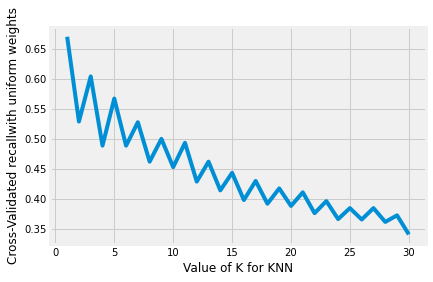

In [148]:
opt_k(X,y,'recall', 'uniform')

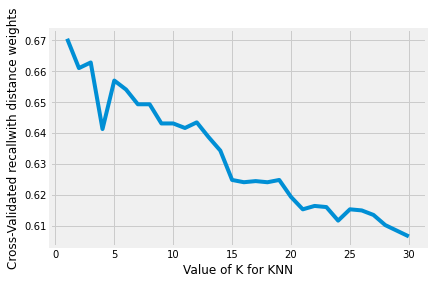

In [149]:
opt_k(X,y,'recall', 'distance')

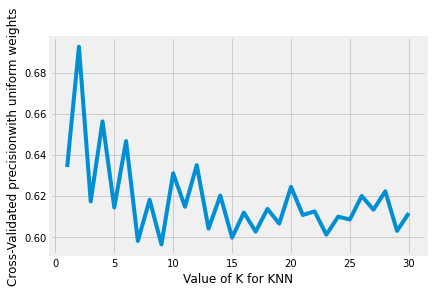

In [150]:
opt_k(X,y, 'precision', 'uniform')

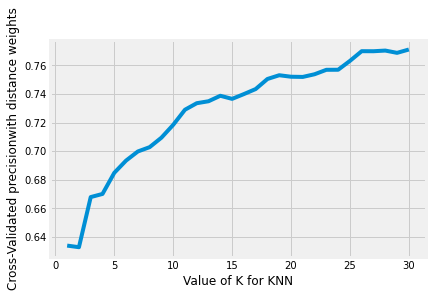

In [151]:
opt_k(X,y, 'precision', 'distance')

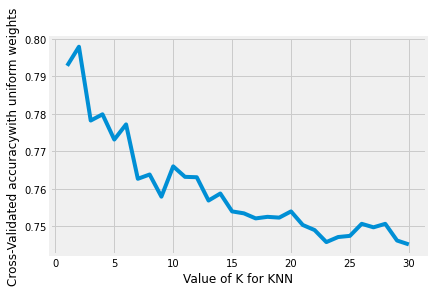

In [153]:
opt_k(X,y, 'accuracy', 'uniform')

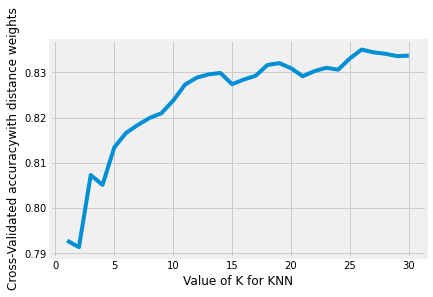

In [152]:
opt_k(X,y, 'accuracy', 'distance')

**Why is one graph going down with K and the other going up with K for accuracy and precision?**

# Now I am going to do a quick test for the logreg, decision tree and random forest methods

In [164]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [183]:
logreg = LogisticRegression(max_iter = 1000, C = 1000)
print(quick_test(logreg, X, y))
print(quick_test_afew_times(logreg, X, y))

0.7270531400966184


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7349551414768806


In [185]:
decisiontree = DecisionTreeClassifier(max_depth=10)
print(quick_test(randomforest, X, y))
print(quick_test_afew_times(decisiontree, X, y))

0.898895790200138
0.8138026224982747


**Why don't we test/train split on the decision tree and randomforest?**
Always test/train split

**Is feature engineering important in decision tree and random forest?**
Always important 
But in non-linear classification models: don't worry about scaling or linearizing the data

**Do decision trees require scaling?**
For standard scaling - no
Hyperparameter to limit size trees - yes

In [179]:
randomforest = RandomForestClassifier(n_estimators=100)
print(quick_test(randomforest, X, y))
print(quick_test_afew_times(randomforest, X, y))

0.8947550034506556
0.899344375431332


Accuracy: randomforest > decisiontree > logistic regression
I'd like to look at some other metrics though, in particular recall

In [195]:
def accuracy(actuals, preds):
    return np.mean(actuals == preds)

def precision(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fp = np.sum((actuals == 0) & (preds == 1))
    return tp / (tp + fp)

def recall(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fn = np.sum((actuals == 1) & (preds == 0))
    return tp / (tp + fn)

def F1(actuals, preds):
    p, r = precision(actuals, preds), recall(actuals, preds)
    return 2*p*r / (p + r)

In [196]:
logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)
decisiontree.fit(X_train, y_train)
randomforest.fit(X_train, y_train)

print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, logreg.predict(X_test)), 
         precision(y_test, logreg.predict(X_test)), 
         recall(y_test, logreg.predict(X_test)),
         F1(y_test, logreg.predict(X_test))))

print('\n')

print('5 nearest neighbors validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, knn.predict(X_test)), 
         precision(y_test, knn.predict(X_test)), 
         recall(y_test, knn.predict(X_test)),
         F1(y_test, knn.predict(X_test))))

print('\n')

print('Decisiontree max depth 10 validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, decisiontree.predict(X_test)), 
         precision(y_test, decisiontree.predict(X_test)), 
         recall(y_test, decisiontree.predict(X_test)),
         F1(y_test, decisiontree.predict(X_test))))

print('\n')

print('Random Forest max depth 10 validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, randomforest.predict(X_test)), 
         precision(y_test, randomforest.predict(X_test)), 
         recall(y_test, randomforest.predict(X_test)),
         F1(y_test, randomforest.predict(X_test))))

Logistic regression validation metrics: 
 Accuracy: 0.7246 
 Precision: 0.5988 
 Recall: 0.1720 
 F1: 0.2672


5 nearest neighbors validation metrics: 
 Accuracy: 0.7971 
 Precision: 0.6861 
 Recall: 0.5621 
 F1: 0.6179


Decisiontree max depth 10 validation metrics: 
 Accuracy: 0.8131 
 Precision: 0.6986 
 Recall: 0.6330 
 F1: 0.6642


Random Forest max depth 10 validation metrics: 
 Accuracy: 0.9006 
 Precision: 0.8750 
 Recall: 0.7695 
 F1: 0.8189


**How would I increase recall in my best method?**
1) Model selection - random forest seems to work best
2) Feature engineering - I put my logic below
3) Handle class imbalance -
4) Hyperparameter tuning
5) Threshold selection

## Feature Engineering
### Very general characteristics of GPCR ligands 
- Binds in a more hydrophobic environment (so tends to have lower octanol/water partition coefficient)
- Molecular mass of ligands have a huge range 
- H-bonds donors and acceptors are very important in binding
- Heavy atom count will skew higher due to peptide ligands



In [232]:
# Normalize for molecular mass
df_class['XLogP_Mass'] = df_class['XLogP']/df_class['ExactMass']
df_class['HBondAcceptorCount_Mass'] = df_class['HBondAcceptorCount']/df_class['ExactMass']
df_class['HBondDonorCount_Mass'] = df_class['HBondDonorCount']/df_class['ExactMass']
df_class['HeavyAtomCount_Mass'] = df_class['HeavyAtomCount']/df_class['ExactMass']

In [236]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, y_train)
y_train_preds = predict

RandomForestClassifier()

In [235]:
X = df_class.select_dtypes(include = 'number', exclude = 'object')
X.drop(['GPCR'], axis = 1, inplace = True)
y = df_class['GPCR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
randomforest.fit(X_train, y_train)

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [206]:
# !conda install -c conda-forge imbalanced-learn

import imblearn.over_sampling

In [207]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

In [223]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_train_OS, y_train_OS = ROS.fit_resample(X_train, y_train)
rf_OS = RandomForestClassifier(n_estimators=100)
rf_OS.fit(X_train_rs, y_train_rs)

print('Random Forest with over sampling : \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, rf_OS.predict(X_test)), 
         precision(y_test, rf_OS.predict(X_test)), 
         recall(y_test, rf_OS.predict(X_test)),
         F1(y_test, rf_OS.predict(X_test))))


smote = imblearn.over_sampling.SMOTE(sampling_strategy = ratio, random_state=42) 

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
rf_SMOTE = RandomForestClassifier(n_estimators=100)
rf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)

print('Random Forest with over sampling : \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, rf_SMOTE.predict(X_test)), 
         precision(y_test, rf_SMOTE.predict(X_test)), 
         recall(y_test, rf_SMOTE.predict(X_test)),
         F1(y_test, rf_SMOTE.predict(X_test))))


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (8684) in class 1 will be larger than the number of samples in the majority class (class #0 -> 5555)
  warnings.warn(


Random Forest with over sampling : 
 Accuracy: 0.8965 
 Precision: 0.8297 
 Recall: 0.8121 
 F1: 0.8208


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (8684) in class 1 will be larger than the number of samples in the majority class (class #0 -> 5555)
  warnings.warn(


Random Forest with over sampling : 
 Accuracy: 0.8898 
 Precision: 0.7817 
 Recall: 0.8635 
 F1: 0.8206
